# Image Preprocessing with Upscaling

In [4]:
import os
import cv2
import numpy as np
from pathlib import Path
from tqdm import tqdm

# Base directories
RAW_DATA_DIR = Path("../Dataset/Raw Dataset/SipakMed Dataset")
PREPROCESSED_DATA_DIR = Path("../Dataset/Preprocessed Enhanced Dataset")

# Get all class folders
classes = [d for d in RAW_DATA_DIR.iterdir() if d.is_dir()]

def enhance_image_resolution(image):
    """
    Enhance image resolution using various techniques
    """
    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    lab[:,:,0] = clahe.apply(lab[:,:,0])
    enhanced = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    
    # Apply unsharp masking for sharpening
    gaussian = cv2.GaussianBlur(enhanced, (0, 0), 2.0)
    unsharp_mask = cv2.addWeighted(enhanced, 1.5, gaussian, -0.5, 0)
    
    # Denoise while preserving edges
    denoised = cv2.bilateralFilter(unsharp_mask, 9, 75, 75)
    
    return denoised

def crop_or_pad_to_square(image, target_size=256):
    """
    Crop or pad image to square while maintaining aspect ratio
    """
    h, w = image.shape[:2]
    
    if h == w:
        # Already square, just resize
        return cv2.resize(image, (target_size, target_size), interpolation=cv2.INTER_CUBIC)
    
    # Make it square by cropping or padding
    size = max(h, w)
    
    # Create a square canvas
    if len(image.shape) == 3:
        square_img = np.zeros((size, size, 3), dtype=image.dtype)
    else:
        square_img = np.zeros((size, size), dtype=image.dtype)
    
    # Calculate padding/cropping offsets
    if h > w:
        # Pad width (add to sides)
        start_x = (size - w) // 2
        square_img[:, start_x:start_x+w] = image
    else:
        # Pad height (add to top/bottom)
        start_y = (size - h) // 2
        square_img[start_y:start_y+h, :] = image
    
    # Resize to target size
    return cv2.resize(square_img, (target_size, target_size), interpolation=cv2.INTER_CUBIC)

def center_crop_to_square(image, crop_size=None):
    """
    Center crop image to square format
    """
    h, w = image.shape[:2]
    
    if crop_size is None:
        crop_size = min(h, w)
    
    # Calculate center crop coordinates
    start_y = (h - crop_size) // 2
    start_x = (w - crop_size) // 2
    
    return image[start_y:start_y+crop_size, start_x:start_x+crop_size]

def extract_and_save_crops(class_path, class_name):
    inner_dir = class_path / class_name  # e.g., im_Dyskeratotic/im_Dyskeratotic
    output_dir = PREPROCESSED_DATA_DIR / class_name
    output_dir.mkdir(parents=True, exist_ok=True)

    # Get .dat files for cyt/nuc
    dat_files = [f for f in inner_dir.glob("*.dat") if "_cyt" in f.name or "_nuc" in f.name]

    for dat_path in tqdm(dat_files, desc=f"Processing {class_name}"):
        image_id = dat_path.stem.split("_")[0]  # '001'
        image_path = inner_dir / f"{image_id}.bmp"

        if not image_path.exists():
            print(f"Image not found for {dat_path.name}, skipping.")
            continue

        img = cv2.imread(str(image_path))
        if img is None:
            print(f"Failed to load image: {image_path}")
            continue

        # Read (x, y) points from .dat file
        with open(dat_path, "r") as f:
            coords = [list(map(float, line.strip().split(","))) for line in f if "," in line]

        if len(coords) < 3:
            print(f"Invalid polygon in {dat_path.name}, skipping.")
            continue

        points = np.array(coords, dtype=np.int32)
        x, y, w, h = cv2.boundingRect(points)

        # Extract the region of interest with some padding
        padding = 10  # Add some context around the cell
        x1 = max(0, x - padding)
        y1 = max(0, y - padding)
        x2 = min(img.shape[1], x + w + padding)
        y2 = min(img.shape[0], y + h + padding)
        
        crop = img[y1:y2, x1:x2]

        # Enhance image resolution before processing
        enhanced_crop = enhance_image_resolution(crop)

        # Method 1: Center crop to square (preserves original resolution in center)
        if min(enhanced_crop.shape[:2]) >= 224:
            center_cropped = center_crop_to_square(enhanced_crop, 224)
        else:
            # If crop is too small, use padding method
            center_cropped = crop_or_pad_to_square(enhanced_crop, 224)

        # Method 2: Pad to square (preserves entire image)
        padded_square = crop_or_pad_to_square(enhanced_crop, 256)

        # Method 3: High-resolution version with padding
        high_res_square = crop_or_pad_to_square(enhanced_crop, 512)

        # Save different versions
        label = "cyt" if "_cyt" in dat_path.name else "nuc"
        base_name = f"{image_id}_{label}_{dat_path.stem.split('_')[-1]}"
        
        # Save center cropped version (224x224)
        center_crop_path = output_dir / f"{base_name}_center_crop.png"
        cv2.imwrite(str(center_crop_path), center_cropped)
        
        # Save padded square version (256x256)
        padded_path = output_dir / f"{base_name}_padded_256.png"
        cv2.imwrite(str(padded_path), padded_square)
        
        # Save high-resolution version (512x512)
        high_res_path = output_dir / f"{base_name}_high_res_512.png"
        cv2.imwrite(str(high_res_path), high_res_square)

# Loop through all classes and process
for class_dir in classes:
    class_name = class_dir.name  # e.g., im_Dyskeratotic
    extract_and_save_crops(class_dir, class_name)

print("✅ All classes processed and saved to Preprocessed Enhanced Dataset.")
print("📁 Output directory:", PREPROCESSED_DATA_DIR)
print("🔍 Generated versions for each image:")
print("   - Center crop (224x224): Preserves center region at original resolution")
print("   - Padded square (256x256): Preserves entire image with padding")
print("   - High resolution (512x512): Enhanced resolution for detailed analysis")

Processing im_Dyskeratotic:   0%|          | 0/1626 [00:00<?, ?it/s]

Processing im_Superficial-Intermediate: 100%|██████████| 1662/1662 [01:26<00:00, 19.13it/s]

✅ All classes processed and saved to Preprocessed Enhanced Dataset.
📁 Output directory: ..\Dataset\Preprocessed Enhanced Dataset
🔍 Generated versions for each image:
   - Center crop (224x224): Preserves center region at original resolution
   - Padded square (256x256): Preserves entire image with padding
   - High resolution (512x512): Enhanced resolution for detailed analysis


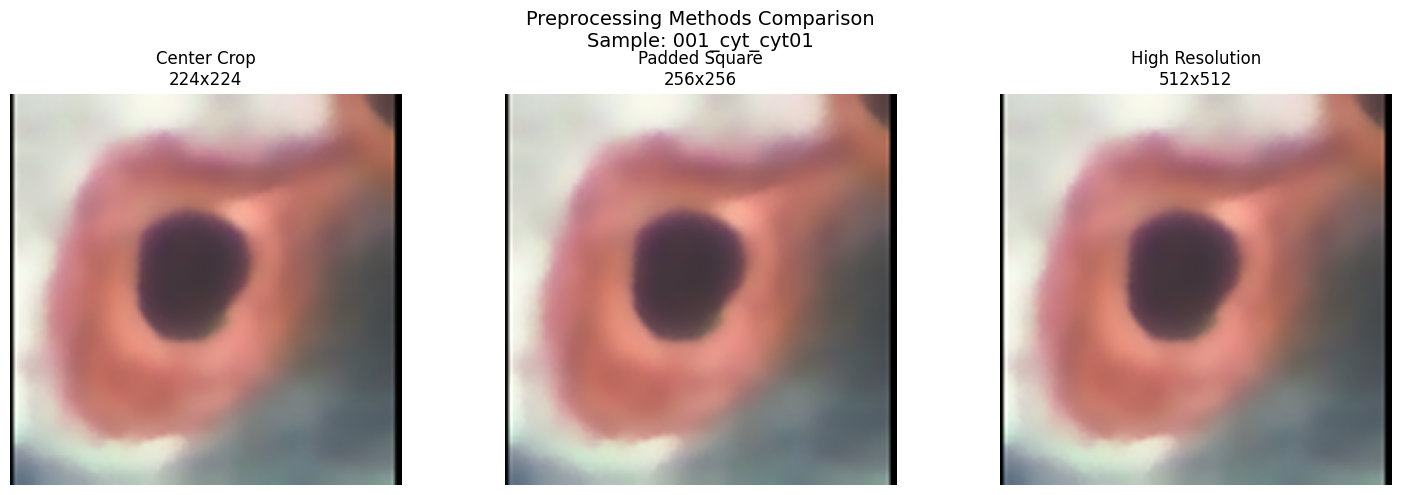


📊 Image Statistics for 001_cyt_cyt01:
  Center Crop: Shape (224, 224, 3), Mean brightness: 142.5, Std: 56.0
  Padded Square: Shape (256, 256, 3), Mean brightness: 142.5, Std: 56.1
  High Resolution: Shape (512, 512, 3), Mean brightness: 142.5, Std: 56.1


In [5]:
# Compare the different preprocessing methods by visualizing sample images
import matplotlib.pyplot as plt
import glob

def compare_preprocessing_methods():
    """
    Compare different preprocessing methods side by side
    """
    # Find a sample processed image
    sample_dirs = list(PREPROCESSED_DATA_DIR.glob("*/"))
    if not sample_dirs:
        print("No processed images found. Please run the preprocessing first.")
        return
    
    sample_dir = sample_dirs[0]
    
    # Find different versions of the same image
    image_files = list(sample_dir.glob("*_center_crop.png"))
    if not image_files:
        print("No processed images found. Please run the preprocessing first.")
        return
    
    sample_file = image_files[0]
    base_name = sample_file.stem.replace("_center_crop", "")
    
    # Load different versions
    center_crop_path = sample_dir / f"{base_name}_center_crop.png"
    padded_path = sample_dir / f"{base_name}_padded_256.png"
    high_res_path = sample_dir / f"{base_name}_high_res_512.png"
    
    images = []
    titles = []
    
    if center_crop_path.exists():
        img = cv2.imread(str(center_crop_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
        titles.append(f"Center Crop\n{img.shape[0]}x{img.shape[1]}")
    
    if padded_path.exists():
        img = cv2.imread(str(padded_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
        titles.append(f"Padded Square\n{img.shape[0]}x{img.shape[1]}")
    
    if high_res_path.exists():
        img = cv2.imread(str(high_res_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
        titles.append(f"High Resolution\n{img.shape[0]}x{img.shape[1]}")
    
    # Create comparison plot
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    if len(images) == 1:
        axes = [axes]
    
    for i, (img, title) in enumerate(zip(images, titles)):
        axes[i].imshow(img)
        axes[i].set_title(title)
        axes[i].axis('off')
    
    plt.suptitle(f"Preprocessing Methods Comparison\nSample: {base_name}", fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\n📊 Image Statistics for {base_name}:")
    for img, title in zip(images, titles):
        print(f"  {title.split()[0]} {title.split()[1]}: Shape {img.shape}, "
              f"Mean brightness: {np.mean(img):.1f}, Std: {np.std(img):.1f}")

# Run the comparison
compare_preprocessing_methods()

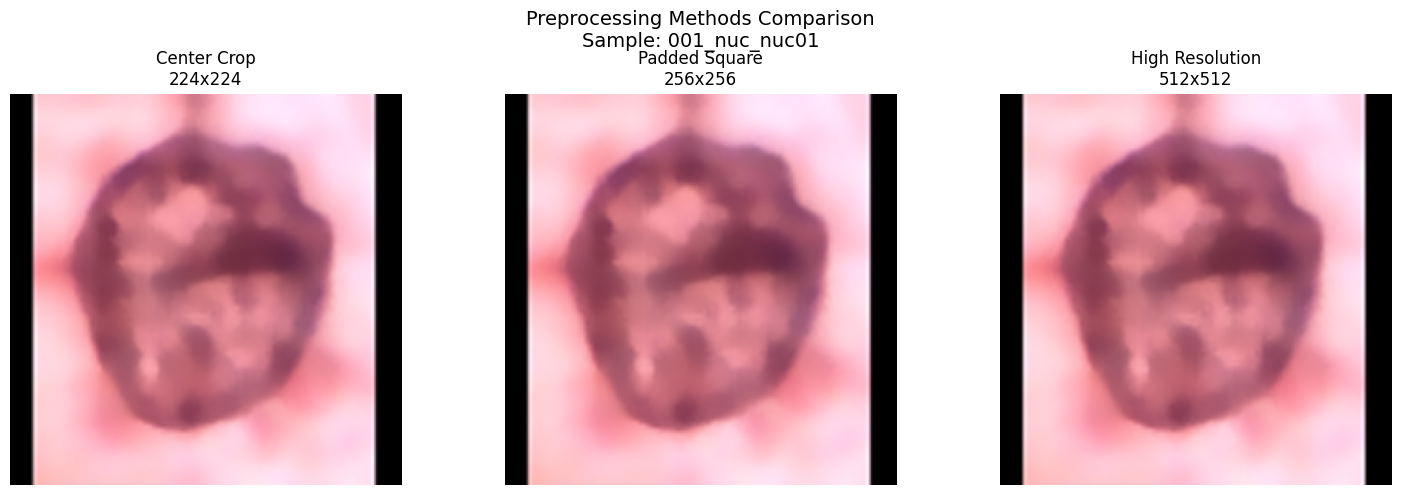


📊 Image Statistics for 001_nuc_nuc01:
  Center Crop: Shape (224, 224, 3), Mean brightness: 156.8, Std: 79.6
  Padded Square: Shape (256, 256, 3), Mean brightness: 156.8, Std: 79.7
  High Resolution: Shape (512, 512, 3), Mean brightness: 156.7, Std: 79.7


In [6]:
# Compare the different preprocessing methods by visualizing sample images
import matplotlib.pyplot as plt
import glob

def compare_preprocessing_methods():
    """
    Compare different preprocessing methods side by side
    """
    # Find a sample processed image
    sample_dirs = list(PREPROCESSED_DATA_DIR.glob("*/"))
    if not sample_dirs:
        print("No processed images found. Please run the preprocessing first.")
        return
    
    sample_dir = sample_dirs[1]
    
    # Find different versions of the same image
    image_files = list(sample_dir.glob("*_center_crop.png"))
    if not image_files:
        print("No processed images found. Please run the preprocessing first.")
        return
    
    sample_file = image_files[1]
    base_name = sample_file.stem.replace("_center_crop", "")
    
    # Load different versions
    center_crop_path = sample_dir / f"{base_name}_center_crop.png"
    padded_path = sample_dir / f"{base_name}_padded_256.png"
    high_res_path = sample_dir / f"{base_name}_high_res_512.png"
    
    images = []
    titles = []
    
    if center_crop_path.exists():
        img = cv2.imread(str(center_crop_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
        titles.append(f"Center Crop\n{img.shape[0]}x{img.shape[1]}")
    
    if padded_path.exists():
        img = cv2.imread(str(padded_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
        titles.append(f"Padded Square\n{img.shape[0]}x{img.shape[1]}")
    
    if high_res_path.exists():
        img = cv2.imread(str(high_res_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
        titles.append(f"High Resolution\n{img.shape[0]}x{img.shape[1]}")
    
    # Create comparison plot
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    if len(images) == 1:
        axes = [axes]
    
    for i, (img, title) in enumerate(zip(images, titles)):
        axes[i].imshow(img)
        axes[i].set_title(title)
        axes[i].axis('off')
    
    plt.suptitle(f"Preprocessing Methods Comparison\nSample: {base_name}", fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\n📊 Image Statistics for {base_name}:")
    for img, title in zip(images, titles):
        print(f"  {title.split()[0]} {title.split()[1]}: Shape {img.shape}, "
              f"Mean brightness: {np.mean(img):.1f}, Std: {np.std(img):.1f}")

# Run the comparison
compare_preprocessing_methods()

## Image Preprocessing Improvements

The enhanced preprocessing pipeline includes several key improvements:

### 🔍 **Resolution Enhancement Techniques:**
1. **CLAHE (Contrast Limited Adaptive Histogram Equalization)**: Improves local contrast while preventing over-amplification
2. **Unsharp Masking**: Enhances image sharpness and edge definition
3. **Bilateral Filtering**: Reduces noise while preserving important edges

### 📐 **Aspect Ratio Preservation:**
- **Center Cropping**: Extracts the central square region, maintaining original pixel resolution
- **Padding Method**: Adds padding to make images square without distortion
- **No Stretching**: Eliminates distortion that occurs with direct resizing

### 📏 **Multiple Output Sizes:**
- **224x224**: Standard size for many deep learning models
- **256x256**: Balanced size with more detail preservation
- **512x512**: High-resolution version for detailed analysis

### ✅ **Benefits:**
- Maintains cell morphology and relative sizes
- Improves image quality for better feature extraction
- Provides multiple resolution options for different model requirements
- Preserves spatial relationships critical for medical image analysis